# I. Data Retrieval

**0. Installing Dependencies**

In [4]:
#Dependencies
%pip install openpyxl matplotlib pandas darts statsmodels dash -q


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
file_paths = [
    '../../Data/EnergieUebersichtCH-2022.xlsx',
    '../../Data/EnergieUebersichtCH-2023.xlsx',
    '../../Data/EnergieUebersichtCH-2024.xlsx',
]
sheet_name = 'Zeitreihen0h15'
total = 29000

**1. Retrieving Data**

In [6]:
import pandas as pd

In [7]:
if 'dfs_loaded' not in globals():
    dfs = []
    for path in file_paths:
        xls = pd.ExcelFile(path)
        df_year = pd.read_excel(xls, sheet_name=sheet_name, header=1)
        dfs.append(df_year)
    dfs_loaded = True 


Combining all years into a single DataFrame

In [22]:
df = pd.concat(dfs, ignore_index=True)
if not globals().get("NO_VISUALS", False):
    print(df.columns)

Index(['Zeitstempel', 'kWh', 'kWh.1', 'kWh.2', 'kWh.3', 'kWh.4', 'kWh.5',
       'kWh.6', 'kWh.7', 'kWh.8', 'kWh.9', 'kWh.10', 'kWh.11', 'kWh.12',
       'kWh.13', 'kWh.14', 'kWh.15', 'kWh.16', 'kWh.17', 'kWh.18', 'kWh.19',
       'Euro/MWh', 'Euro/MWh.1', 'Euro/MWh.2', 'Euro/MWh.3', 'kWh.20',
       'kWh.21', 'kWh.22', 'kWh.23', 'kWh.24', 'kWh.25', 'kWh.26', 'kWh.27',
       'kWh.28', 'kWh.29', 'kWh.30', 'kWh.31', 'kWh.32', 'kWh.33', 'kWh.34',
       'kWh.35', 'kWh.36', 'kWh.37', 'kWh.38', 'kWh.39', 'kWh.40', 'kWh.41',
       'kWh.42', 'kWh.43', 'kWh.44', 'kWh.45', 'kWh.46', 'kWh.47', 'kWh.48',
       'kWh.49', 'kWh.50', 'kWh.51', 'kWh.52', 'kWh.53', 'kWh.54', 'kWh.55',
       'kWh.56', 'kWh.57', 'kWh.58', 'kWh.59'],
      dtype='object')


In [9]:
column_mapping = { 
    'kWh': 'Total Energy Consumed by End Users (kWh)',
    'kWh.1': 'Total Energy Production (kWh)',
    'kWh.2': 'Total Energy Consumption (kWh)',
    'kWh.3': 'Net Outflow (kWh)',
    'kWh.4': 'Grid Feed-In (kWh)',
    'kWh.5': 'Positive Secondary Control Energy (kWh)',
    'kWh.6': 'Negative Secondary Control Energy (kWh)',
    'kWh.7': 'Positive Tertiary Control Energy (kWh)',
    'kWh.8': 'Negative Tertiary Control Energy (kWh)'
}

df.rename(columns=column_mapping, inplace=True)

II. Data Cleaning

In [10]:
import plotly.express as px

df.loc[df['Total Energy Consumption (kWh)'].isna(), 'color'] = 'Total Energy Consumption'

# Mask for rows with any NA values
mask = df.isna().any(axis=1)
df_missing = df[mask].copy()
df_missing['is_missing'] = True  # optional for consistent y-axis
if not globals().get("NO_VISUALS", False):

    # Scatter plot
    fig = px.scatter(
        data_frame=df_missing,
        x=df_missing.index,
        y='is_missing',
        color='color',
        title='Scatterplot of the empty loads (Actual)',
        labels={'x': 'Date', 'is_missing': 'Missing Entry', 'color': ''}
    )
    fig.show()


Is each index unique?

In [11]:
df.index.is_unique

True

Check min, max, std for anomalies

In [12]:
if not globals().get("NO_VISUALS", False):
    print(df.describe()) 

       Total Energy Consumed by End Users (kWh)  \
count                              1.052160e+05   
mean                               1.542535e+06   
std                                2.940349e+05   
min                                8.924723e+05   
25%                                1.310793e+06   
50%                                1.529540e+06   
75%                                1.732389e+06   
max                                2.399117e+06   

       Total Energy Production (kWh)  Total Energy Consumption (kWh)  \
count                   1.052160e+05                    1.052160e+05   
mean                    1.941888e+06                    1.790474e+06   
std                     5.681439e+05                    2.655080e+05   
min                     8.139795e+05                    1.038507e+06   
25%                     1.488755e+06                    1.610280e+06   
50%                     1.811326e+06                    1.796067e+06   
75%                     2.320503e+06

1.1 Aggregate Data by day

In [13]:
df['Zeitstempel'] = pd.to_datetime(
    df['Zeitstempel'],
    format='%d.%m.%Y %H:%M',   
    dayfirst=True,            
    errors='raise'            
)


In [14]:
df = df.set_index('Zeitstempel')
df = df.resample('7D').sum()

Recalculate total by 24h

In [15]:
total = int ((total / 96) -1) 
print(total)

301


In [16]:
time_index = df.index

Save backup 

In [17]:
df_backup = df

**2. Data variables / potential parameters** 

**Pre-processing step** Renaming column names to be clear

In [18]:
column_mapping = { 
    'kWh': 'Total Energy Consumed by End Users (kWh)',
    'kWh.1': 'Total Energy Production (kWh)',
    'kWh.2': 'Total Energy Consumption (kWh)',
    'kWh.3': 'Net Outflow (kWh)',
    'kWh.4': 'Grid Feed-In (kWh)',
    'kWh.5': 'Positive Secondary Control Energy (kWh)',
    'kWh.6': 'Negative Secondary Control Energy (kWh)',
    'kWh.7': 'Positive Tertiary Control Energy (kWh)',
    'kWh.8': 'Negative Tertiary Control Energy (kWh)'
}

df.rename(columns=column_mapping, inplace=True)

The goal is to predict the next element of the Total Energy Consumption columb:

In [19]:
energy_consumption_data = df['Total Energy Consumption (kWh)'].values

In [20]:
import matplotlib.pyplot as plt

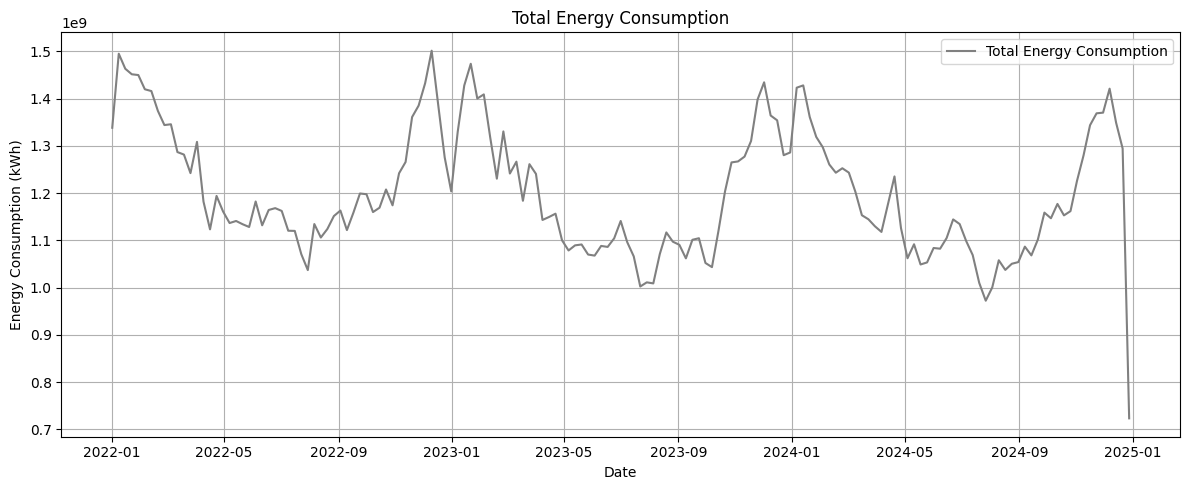

In [21]:
if not globals().get("NO_VISUALS", False):
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(df['Total Energy Consumption (kWh)'], label='Total Energy Consumption', color='gray')
    ax.set_title('Total Energy Consumption')
    ax.set_xlabel('Date')
    ax.set_ylabel('Energy Consumption (kWh)')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()